# **ML2: Versión normalización Logarítmica - Ezau Faridh Torres Torres**


**INSTRUCCIONES**: Crear un modelo de codificador (encoder) de transformer para dada una serie de K entradas (horas) de valores de criptomonedas predecir los precios de las siguientes k horas. (ver  descripción en la tarea 2).

1. El transformer (encoder) debe constar de al menos 3 etapas. La salida debe ser directamente la predicción. 

2. Probar normalización: logarítmica y banqueo (restar min y dividir entre  (max-min) a cada cripto en la serie). 

3. Usra el prositional encoder propuesto en el Transfromer original.

4. Probar vs asumir que el precio de la criptomoneda no cambia durante el periodo de predicción. y vs el seq2seq con atención de la tarea 2. 

5. Implementar en tensorflow o pytorch usando las "layers" ya implementadas en las librerías. No se vale usar ya un transformer implementado. Usar Tensorflow (MultiHeadAttention) y pytorch (torch.nn.MultiheadAttention).

# **Descripción General:**

En este script, se implementa un modelo Transformer con ayuda de TensorFlow, se comienzan extrayendo los datos tal y como se realizó en la Tarea 2: Cada vez que este scrit corra la sección de Preparación de Datos, la base de datos se actualizará a los datos actuales ya que se inicializa con las últimos 100 horas de los valores de las criptomonedas (al momento). Se implementa además el modelo Seq2Seq de la tarea 2 para hacer una comparación entre el desempeño de ambos métodos con mismo espacio latente $64$ y mismo número de epocas $1000$.

Además, se usa el **MinMaxScaler** de **sklearn** debido a la diferencia de magnitudes entre los costos de las monedas. Para ver la implementación usando normalización por banqueo, ver el otro notebook adjunto.

En la sección:
1. Se cargan las librerías necesarias tanto para Seq2Seq como el modelo Transformer.
2. Se descargan los datos como se hizo en la tarea 2 y se realiza la normalización logarítmica, las monedas elegidas son las mismas:
- Bitcoin
- Ethereum
- Dogecoin
- Cardano
- Litecoin
- Solana
- Polkadot

3. Se implementa el modelo Seq2Seq con Teacher Forcing usando $64$ de dimensión latente, $1000$ épocas y un batch size de $32$. El resto de la implementación es idéntica a la de la tarea 2.

4. Esta parte del código define un modelo Transformer con Positional Enconding. Utiliza 4 capas de atención y 8 capas de atención. El modelo toma entradas escaladas de los precios, las transforma mediante bloques de atención, y predice los valores futuros de las criptomonedas. Luego, entrena el modelo y genera predicciones que se desescalan para compararlas con los valores reales.

5. Se grafican los resultados para los casos de predicciones con Seq2Seq y el Transformer, así como el MSE para cada caso.

6. Se dan las conclusiones principales.

# **1.- Librerías**

In [1]:
import yfinance as yf
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Input, LayerNormalization, MultiHeadAttention
from tensorflow.keras.layers import Attention, Concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error

# **2.- Preparación de Datos**

## **2.1.- Descarga de datos**

Se descargan las listas de los datos históricos de las 7 criptomonedas. Dado que se utilizan $100$ horas en todo el proceso, basta tomar los datos históricos de los últimos días. En particular, se descargan los datos del último mes. La categoría de interés es el precio de cierre de cada criptomoneda, se construye un DataFrame con los precios de cierre de todas las criptomonedas. Después, se eliminan filas con valores nulos y se seleccionan los últimos 101 puntos temporales para trabajar.

In [2]:
# Definición de las criptomonedas a analizar
cryptos = ['BTC-USD','ETH-USD','DOGE-USD','ADA-USD','LTC-USD','SOL-USD','DOT-USD']
# Los nombres de estas monedas son:
nombres_columnas = ['Bitcoin','Ethereum','Dogecoin','Cardano','Litecoin','Solana','Polkadot']
# Descargar datos
data = {}
for crypto in cryptos:
    data[crypto] = yf.download(tickers=crypto, period='1mo', interval='1h')

# Se selecciona el valor de 'Close' para cada criptomoneda
df = pd.DataFrame({crypto: data[crypto]['Close'] for crypto in cryptos})
df = df.dropna()         # Eliminar filas con valores nulos
T = 100+1                # Número de pasos en el tiempo
t = 5                    # Número de pasos en el futuro
df = df.iloc[-T:]        # Seleccionar los últimos T puntos 
n_cryp = df.shape[1]     # Número de criptomonedas (características)
X = df.iloc[:T-t].values # Primeros T-t puntos
Y = df.iloc[T-t:].values # Últimos t puntos

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### **2.1.1.- Normalización Logarítmica**

In [3]:
# Escalar los datos
X_log = np.expand_dims(np.log(X), axis = 0) # Escalar primeros T-t puntos
Y_log = np.expand_dims(np.log(Y), axis = 0) # Escalar últimos t puntos

# **3.- Modelo Seq2Seq**

Se propuso usar $64$ neuronas en las capas LSTM y $750$ épocas.

In [4]:
# Parámetros del modelo
latent_LSTM = 64    # Dimensión del espacio latente (número de neuronas en la capa LSTM)
len_input   = T - t # Longitud de la entrada (número de puntos en la serie temporal, 95)
epochs      = 1000  # Número de épocas
batch_size  = 32    # Tamaño del lote    

# Encoder
encoder_inputs = Input(shape=(len_input, n_cryp))                          # Entrada del codificador
encoder_lstm = LSTM(latent_LSTM, return_sequences=True, return_state=True) # Capa LSTM
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)           # Salida del codificador
encoder_states = [state_h, state_c]                                        # Estados del codificador

# Decoder
decoder_inputs = Input(shape = (t,n_cryp))                                      # Entrada del decodificador
decoder_lstm = LSTM(latent_LSTM, return_sequences = True, return_state = True)  # Capa LSTM
decoder_outputs,_,_ = decoder_lstm(decoder_inputs,initial_state=encoder_states) # Salida del decodificador

# Atención
attention = Attention(score_mode = "dot")                       # Capa de atención
vector_contexto = attention([decoder_outputs, encoder_outputs]) # Salida de la atención

# Se concatena la salida del decodificador con la atención
decoder_context = Concatenate(axis=-1)([decoder_outputs, vector_contexto]) 

# Capa densa de salida
decoder_dense = Dense(n_cryp, activation = 'linear')  # Capa de salida
decoder_outputs = decoder_dense(decoder_context)      # Salida de la capa de salida

# Definir el modelo Seq2Seq con atención
Seq2Seq = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compilar el modelo
Seq2Seq.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Resumen del modelo
Seq2Seq.summary()

# Entrenamiento con Teacher Forcing
decoder_input_data = np.zeros_like(Y_log)       # Inicializamos con ceros
decoder_input_data[:, 1:, :] = Y_log[:, :-1, :] # El decoder recibe el target desplazado como entrada

# Entrenar el modelo
historyMinMax = Seq2Seq.fit([X_log, decoder_input_data], Y_log, batch_size=batch_size, epochs=epochs)

# Realizar predicciones usando el modelo entrenado
predicciones = Seq2Seq.predict([X_log, decoder_input_data])

# Desescalar las predicciones y los valores reales para comparar
prediccionesSeq2Seq = np.exp(predicciones[0])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5, 7)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 96, 64),  │     18,432 │ input_layer[0][0] │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 5, 64),   │     18,432 │ input_layer_1[0]… │
│                     │ (None, 64),       │            │ lstm[0][1],       │
│                     │ (None, 64)]       │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 5, 64)     │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5, 128)    │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5, 7)      │        903 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,767 (147.53 KB)

 Trainable params: 37,767 (147.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step - loss: 34.9677 - mae: 4.7548
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 33.2992 - mae: 4.6598
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 31.6971 - mae: 4.5509
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 30.1668 - mae: 4.4385
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 28.7006 - mae: 4.3235
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 27.2957 - mae: 4.2069
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 25.9533 - mae: 4.0899
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 24.6749 - mae: 3.9733
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 23.4612 - mae: 3.8582
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 22.3139 - mae: 3.7461
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 21.2374 - mae: 3.6381
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 20.2297 - mae: 3.5335
Epoch 13/1000
1/1 ━━━━━━

# **4.- Modelo Transformer**


In [5]:
# Parámetros del modelo
latent_dim = 64   # Dimensión de las representaciones o embeddings que maneja el modelo
n_heads    = 8    # Número de cabezas de atención
num_layers = 4    # Número de capas del modelo
epochs     = 1000 # Número de épocas
batch_size = 32   # Tamaño del lote

# Positional Encoding (Codificación Posicional)
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, max_len=5000):
        """
        d_model: Tamaño de las representaciones o embeddings que maneja el modelo.
        max_len: Longitud máxima de las secuencias de entrada para las que se calculará la codificación posicional.
        """
        super(PositionalEncoding, self).__init__()
        # Generar la codificación posicional en el constructor para todas las posiciones hasta max_len
        self.pos_encoding = self.positional_encoding(max_len, d_model)
    def positional_encoding(self, max_len, d_model):
        """
        Calcula la matriz de codificación posicional para todas las posiciones hasta max_len y para 
        representaciones de tamaño d_model.
        """
        # Crea un vector con las posiciones de 0 a max_len-1 (dimensión [max_len, 1])
        position = np.arange(max_len)[:, np.newaxis]
        # Crea un vector con los factores de división según la fórmula de codificación posicional
        # Cada dimensión usa una escala diferente que depende de la posición
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        # Inicializa la matriz de codificaciones posicionales con ceros (dimensión [max_len, d_model])
        pos_encoding = np.zeros((max_len, d_model))
        # Aplica seno a las posiciones pares (dimensiones 0, 2, 4, ...) 
        pos_encoding[:, 0::2] = np.sin(position * div_term)
        # Aplica coseno a las posiciones impares (dimensiones 1, 3, 5, ...)
        pos_encoding[:, 1::2] = np.cos(position * div_term)
        # Agrega una dimensión extra para que sea compatible con las entradas del modelo (dimensión [1, max_len, d_model])
        pos_encoding = pos_encoding[np.newaxis, ...]
        # Convierte la matriz de codificación a tipo TensorFlow con formato float32
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        """
        Agregar la codificación posicional a la entrada.
        inputs: Tensor de entrada con forma (batch_size, seq_len, d_model).
        """
        seq_len = tf.shape(inputs)[1]  # Obtener la longitud de la secuencia de entrada
        # Suma la codificación posicional a los embeddings originales (limitado a la longitud real de la secuencia)
        return inputs + self.pos_encoding[:, :seq_len, :]

# Construcción del modelo Transformer
def build_transformer(n_cryp, latent_dim, n_heads, num_layers):
    inputs = Input(shape=(None, n_cryp))
    # Embedding
    x = Dense(latent_dim)(inputs)
    # Positional Encoding
    x = PositionalEncoding(latent_dim)(x)
    # Transformer blocks
    for _ in range(num_layers):
        attention_output = MultiHeadAttention(num_heads=n_heads, key_dim=latent_dim)(x, x)
        attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)
        feed_forward_output = Dense(latent_dim, activation='relu')(attention_output)
        x = LayerNormalization(epsilon=1e-6)(feed_forward_output + attention_output)
    
    # Output layer
    outputs = Dense(n_cryp)(x[:, -t:, :])
    return Model(inputs, outputs)

# Construir modelo
Transf = build_transformer(n_cryp, latent_dim, n_heads, num_layers)
Transf.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
Transf.summary()

# Entrenamiento
historyTransformer = Transf.fit(X_log, Y_log, epochs=epochs, batch_size=batch_size, verbose=1)

# Realizar predicciones usando el modelo entrenado
predicciones = Transf.predict(X_log)

# Desescalar las predicciones y los valores reales para comparar
prediccionesT = np.exp(predicciones[0])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 64)  │        512 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, None, 64)  │          0 │ dense_1[0][0]     │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 64)  │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 64)  │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 64)  │          0 │ dense_2[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None, 64)  │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None, 64)  │          0 │ dense_3[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_4[0][0]     

 Total params: 549,319 (2.10 MB)

 Trainable params: 549,319 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 34.5285 - mae: 4.7955
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 13.5869 - mae: 3.1177
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.8220 - mae: 2.1267
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.0031 - mae: 1.8859
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.7907 - mae: 1.6711
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.9440 - mae: 1.4827
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.3636 - mae: 1.4101
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.9416 - mae: 1.3664
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.6175 - mae: 1.3124
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.3573 - mae: 1.2413
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.1433 - mae: 1.1588
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.9566 - mae: 1.0738
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━

# **5.- Resultados**

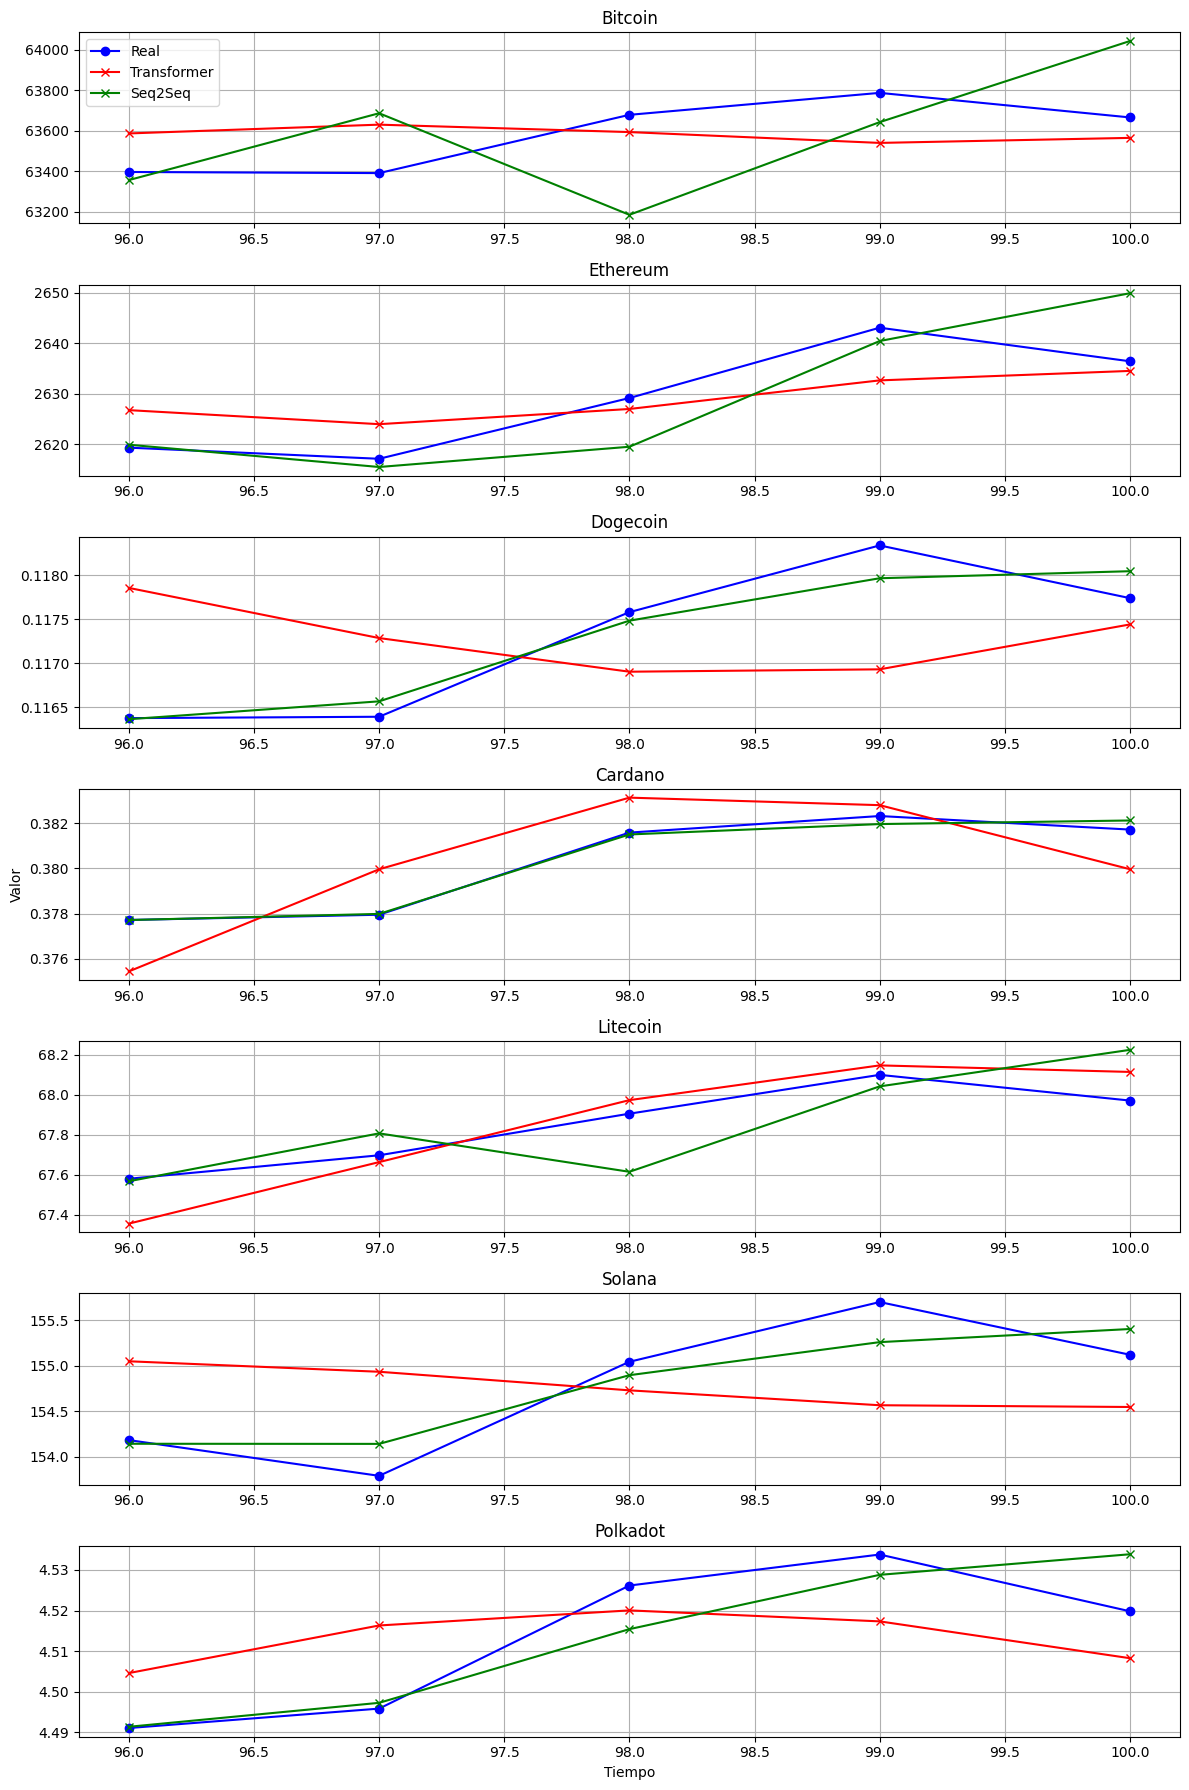

MSE para modelo Seq2Seq    : 14164.393128203013
MSE para modelo Transformer: 4915.2124108740445


In [6]:
# Graficar los resultados
plt.figure(figsize=(12, 18))
for i in range(n_cryp):
    plt.subplot(n_cryp, 1, i + 1)
    plt.plot(range(T - t, T), Y[:, i], label='Real', marker='o', c='blue')
    plt.plot(range(T - t, T), prediccionesT[:, i], label='Transformer', marker='x', c='red')
    plt.plot(range(T - t, T), prediccionesSeq2Seq[:, i], label='Seq2Seq', marker='x', c='green')
    plt.title(nombres_columnas[i])
    plt.grid(True)
    if i == n_cryp - 1:
        plt.xlabel('Tiempo')
    if i == 0:
        plt.legend()
    if i == 3:
        plt.ylabel('Valor')
plt.tight_layout()
plt.show()

mseSeq2Seq = mean_squared_error(Y, prediccionesSeq2Seq)
mseTransformer = mean_squared_error(Y, prediccionesT)
print(f"MSE para modelo Seq2Seq    : {mseSeq2Seq}")
print(f"MSE para modelo Transformer: {mseTransformer}")

# **6.- Conclusiones**

Mientras se implementaba este programa, se iba notando que el Transformer tendría algunos problemas para superar al modelo Seq2Seq. Esto debido a que la ventaja dada por el Teacher Forcing para el modelo Seq2Seq era bastante grande. En la implementación del modelo transformer se notó que iba a necesitar un número mayor de épocas sin importar el número de cabezas y capas de atención que se le pusieran.

Se eligieron los parámetros debido a que fueron los que mostraron los mejores resultados y para ser comparables entre ellos. El número de épocas se eligió de esa forma ya que a partir de 700 épocas, ya no se notaba gran variabilidad entre las pérdidas.

El modelo Transformer tuvo dificultades para igualar el desempeño del modelo Seq2Seq debido a la falta de teacher forcing, lo que afecta su capacidad de generar predicciones precisas de manera iterativa. El Seq2Seq, al incorporar teacher forcing, recibe las predicciones anteriores corregidas, mejorando su entrenamiento. Además, a pesar de usar la misma dimensión en el espacio latente, el Transformer introduce una mayor cantidad de parámetros debido a las capas de atención multi-cabeza y normalización, lo que incrementa el tiempo de entrenamiento y hace que el modelo sea más costoso computacionalmente, sin lograr reducir el MSE al mismo nivel.

Por otro lado, la normalización logarítmica no mostró mejoras significativas en comparación con la normalización Min-Max (quizá un poco mejor para el caso de Seq2Seq). Esto podría deberse a que la transformación logarítmica reduce las diferencias entre los valores altos y bajos, lo que puede dificultar la detección de patrones en datos con variabilidad extrema, algo importante en series temporales financieras, sobre todo en la variabilidad de valores entre las mismas monedas (Bitcoin y Ethereum cuentan con magnitudes mucho mayores a las demás). En cambio, la normalización Min-Max preserva la relación proporcional entre los datos, lo que podría ser más adecuado para capturar las fluctuaciones de los precios.